In [ ]:
import os
os.getcwd()
os.chdir('/home/siyuan/Seafile/Thesis/PycharmProjects/DD_PE_paper/')

In [ ]:
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit import IBMQ, transpile, Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_montreal')

In [ ]:
from src.tools.DD_insertion import construct_udd_sequence, \
                                 kdd_sequences, \
                                 kdd_spacing, \
                                 construct_bv_circuit, \
                                 construct_hs_circuit, \
                                 construct_graph_matrix, \
                                 convert_count_to_prob, \
                                 translate_circuit_to_basis
from qiskit.circuit.library import QFT, GraphState

In [ ]:
bv_circuits = []
hs_circuits = []
qft_circuits = []
for i in range(3, 15):
    bv_circuits.append(construct_bv_circuit(i))

# for i in range(2, 15, 2):
#     hs_circuits.append(construct_hs_circuit(i))

for i in range(3, 15):
    qft_circuits.append(QFT(i))

for circuit in bv_circuits:
    circuit.measure_all()

# for circuit in hs_circuits:
#     circuit.measure_all()

for circuit in qft_circuits:
    circuit.measure_all()

In [ ]:
durations = InstructionDurations.from_backend(backend)
## add duration of y gates which are used for DD sequences
bconf = backend.configuration()
for i in range(bconf.num_qubits):
    x_duration = durations.get('x', i)
    durations.update(InstructionDurations(
        [('y', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('rx', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('ry', i, x_duration)]
        ))

In [ ]:
graph_state_circuits = []
coupling_map = backend.configuration().coupling_map

for i in range(3, 15):
    gs_circuit_matrix = construct_graph_matrix(i, coupling_map)
    graph_state_circuits.append(GraphState(gs_circuit_matrix))

for circuit in graph_state_circuits:
    circuit.measure_all()

In [ ]:
from src.tools.DD_insertion import pm_DD_sequences
pms = pm_DD_sequences(durations)

In [ ]:
bv_job_ids = []
bv_jobs = []

for circuit in bv_circuits:
    circuit_list = []
    transpiled_qc = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=1)
    circuit_list.append(transpiled_qc)
    for pm in pms:
        qc_transpile = pm.run(transpiled_qc)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        circuit_list.append(qc_transpile_base)
    job = backend.run(circuit_list, shots=8192)
    bv_jobs.append(job)
    job_id = job.job_id()
    print(job_id)
    bv_job_ids.append(job_id)

In [ ]:
for job_id in bv_job_ids:
    print(job_id)

In [ ]:
from qiskit import execute

shots = 8192
psts = []
bv_job_ids = [
    '628e21a6ef7069a5d879104d',
    '628e21a997dfca38771294b9',
    '628e21ac4a0d3c434f218103',
    '628e21ba50f23de8abcb5b13',
    '628e21bdd6a0619eb32af846',
    '628e21c10814ba2fdeddd255',
    '628e21c4386b019c711859b7',
    '628e21c8d6a0616b4f2af849',
    '628e21cc50f23d38dacb5b15',
    '628e21d068f4d6c96b83a770',
    '628e21d50814ba70e8ddd257',
    '628e21dc386b0140001859b9',

]
for i, circuit in enumerate(bv_circuits):
    ideal_counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts()
    ideal_result = list(ideal_counts.keys())[0]
    result_counts = backend.retrieve_job(bv_job_ids[i]).result().get_counts()
    pst = []
    for result_count in result_counts:
        pst.append(result_count[ideal_result]/shots)
    psts.append(pst)

bv_circuit_names = ['BV3', 'BV4', 'BV5', 'BV6', 'BV7', 'BV8', 'BV9', 'BV10', 'BV11', 'BV12', 'BV13', 'BV14']
DD_sequences = ['no_dd', 'hahn_X', 'hahn_Y', 'CP', 'CPMG', 'xy4', 'xy8', 'xy16', 'udd1', 'udd2', 'kdd']
bv_results_data = {}

for i, name in enumerate(bv_circuit_names):
    print(f'---------Result of circuit {name} -------------')
    for j, pst in enumerate(psts[i]):
        print(f'pst result of {DD_sequences[j]}: {pst}')
    bv_results_data[name] = psts[i]

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

baseline = []
data = []
for name in bv_circuit_names:
    result_data = bv_results_data[name]
    baseline.append(result_data[0])
    ratio = [i / result_data[0] for i in result_data[1:]]
    data.append(ratio)

data = np.array(data)

# hahn_X = data[:, 0]
# hahn_Y = data[:, 1]
cp = data[1:, 2]
cpmg = data[1:, 3]
xy4 = data[1:, 4]
xy8 = data[1:, 5]
xy16 = list(data[2:, 6])
xy16.insert(0, None)
udd_X = data[1:, 7]
udd_Y = data[1:, 8]
kdd = list(data[2:, 9])
kdd.insert(0, None)

circuit_names = ['BV3', 'BV4', 'BV5', 'BV6', 'BV7', 'BV8', 'BV9', 'BV10', 'BV11', 'BV12', ]

x_ticks = circuit_names[:6]
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure

fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1])

# plt.plot(X, hahn_Y, linestyle='--', marker='o', color='g', label='hahn_X')
# plt.plot(X, hahn_X, linestyle='--', marker='s', color='m', label='hahn_Y')
plt.plot(X, cp[:-2][:6], linestyle='--', marker='o', color='orange', label='cp')
plt.plot(X, cpmg[:-2][:6], linestyle='--', marker='.', color='b', label='cpmg')
plt.plot(X, xy4[:-2][:6], linestyle='--', marker='^', color='r', label='xy4')
plt.plot(X, xy8[:-2][:6], linestyle='--', marker='X', color='g', label='xy8')
plt.plot(X, xy16[:-2][:6], linestyle='--', marker='h', color='c', label='xy16')
plt.plot(X, udd_X[:-2][:6], linestyle='--', marker='d', color='y', label='udd_x')
plt.plot(X, udd_Y[:-2][:6], linestyle='--', marker='+', color='k', label='udd_y')
plt.plot(X, kdd[:-2][:6], linestyle='--', marker='*', color='m', label='kdd')

plt.axhline(1, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=16)
# ax.set_title('Relative PST result for BV circuit on ibmq_guadalupe', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, fontsize=14)
ax.set_ylabel('Relative PST', fontsize=16)
plt.savefig('TQE_Relat_PST_BV_montreal.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
data

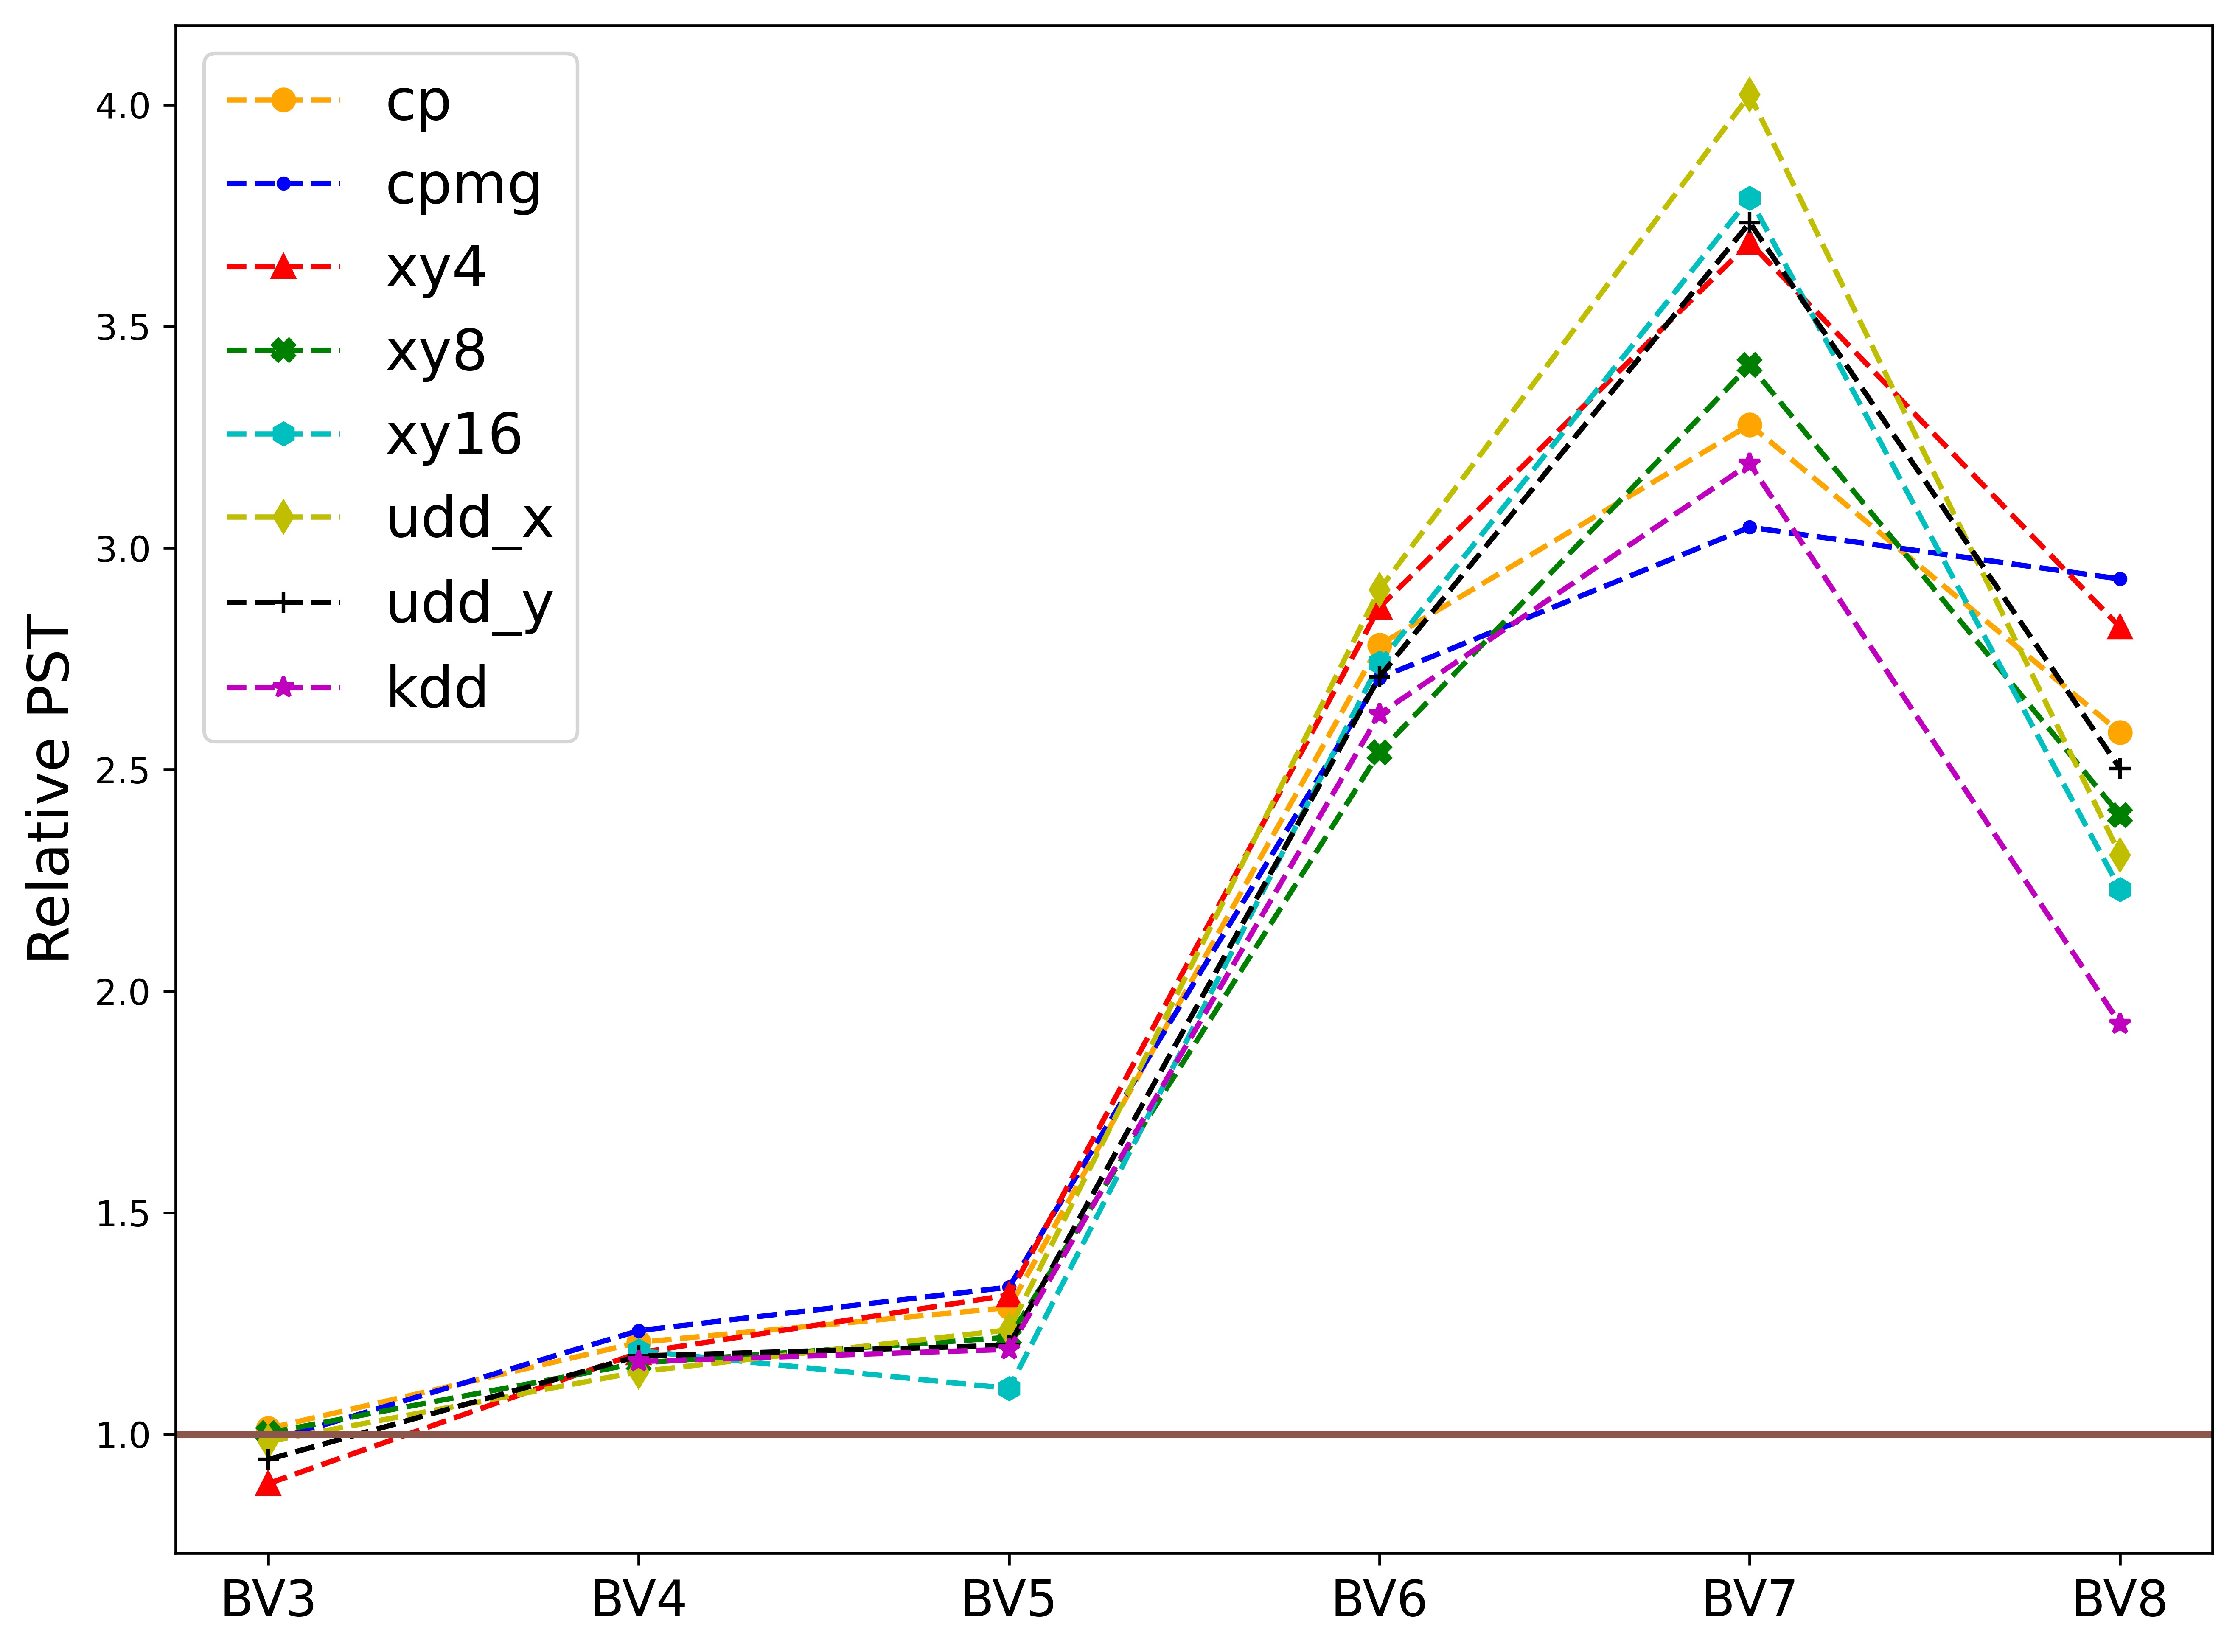

In [10]:

import numpy as np
import matplotlib.pyplot as plt

baseline = []
data = []
for name in bv_circuit_names:
    result_data = bv_results_data[name]
    baseline.append(result_data[0])
    ratio = [i / result_data[0] for i in result_data[1:]]
    data.append(ratio)

data = np.array(data)

# hahn_X = data[:, 0]
# hahn_Y = data[:, 1]
cp = data[1:, 2]
cpmg = data[1:, 3]
xy4 = data[1:, 4]
xy8 = data[1:, 5]
xy16 = list(data[2:, 6])
xy16.insert(0, None)
udd_X = data[1:, 7]
udd_Y = data[1:, 8]
kdd = list(data[2:, 9])
kdd.insert(0, None)

circuit_names = ['BV3', 'BV4', 'BV5', 'BV6', 'BV7', 'BV8', 'BV9', 'BV10', 'BV11', 'BV12', ]

x_ticks = circuit_names[:6]
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure

fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1])

# plt.plot(X, hahn_Y, linestyle='--', marker='o', color='g', label='hahn_X')
# plt.plot(X, hahn_X, linestyle='--', marker='s', color='m', label='hahn_Y')
plt.plot(X, cp[:-2][:6], linestyle='--', marker='o', color='orange', label='cp')
plt.plot(X, cpmg[:-2][:6], linestyle='--', marker='.', color='b', label='cpmg')
plt.plot(X, xy4[:-2][:6], linestyle='--', marker='^', color='r', label='xy4')
plt.plot(X, xy8[:-2][:6], linestyle='--', marker='X', color='g', label='xy8')
plt.plot(X, xy16[:-2][:6], linestyle='--', marker='h', color='c', label='xy16')
plt.plot(X, udd_X[:-2][:6], linestyle='--', marker='d', color='y', label='udd_x')
plt.plot(X, udd_Y[:-2][:6], linestyle='--', marker='+', color='k', label='udd_y')
plt.plot(X, kdd[:-2][:6], linestyle='--', marker='*', color='m', label='kdd')

plt.axhline(1, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=16)
# ax.set_title('Relative PST result for BV circuit on ibmq_guadalupe', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, fontsize=14)
ax.set_ylabel('Relative PST', fontsize=16)
plt.savefig('TQE_Relat_PST_BV_montreal.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
data

array([[ 1.02580828,  1.02382303,  1.0377198 ,  1.03431651,  1.04480998,
         1.03233125,  0.9846852 ,  1.03970505,  1.05275099,  1.03006239],
       [ 0.96066566,  0.96550681,  1.01331316,  0.98396369,  0.88895613,
         1.00332829,  0.93585477,  0.98396369,  0.94341906,  0.84205749],
       [ 1.01536984,  0.98991354,  1.2074928 ,  1.2339097 ,  1.18395773,
         1.16090298,  1.18876081,  1.14121037,  1.17675312,  1.16426513],
       [ 1.03075346,  1.01640185,  1.28600718,  1.33213737,  1.31419785,
         1.21886212,  1.10353665,  1.23577652,  1.2009226 ,  1.19169657],
       [ 1.05820722,  0.95925495,  2.78114086,  2.70663562,  2.8661234 ,
         2.53899884,  2.74039581,  2.90570431,  2.70896391,  2.62514552],
       [ 0.98963731,  1.00345423,  3.27806563,  3.04663212,  3.68911917,
         3.41278066,  3.78929188,  4.0224525 ,  3.73402418,  3.18998273],
       [ 1.09338521,  1.12062257,  2.58365759,  2.92996109,  2.82101167,
         2.39688716,  2.22957198,  2.307393  

In [12]:
gs_job_ids = []
gs_jobs = []

for circuit in graph_state_circuits:
    circuit_list = []
    transpiled_qc = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=1)
    circuit_list.append(transpiled_qc)
    for pm in pms:
        qc_transpile = pm.run(transpiled_qc)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        circuit_list.append(qc_transpile_base)
    job = backend.run(circuit_list, shots=8192)
    gs_jobs.append(job)
    job_id = job.job_id()
    print(job_id)
    gs_job_ids.append(job_id)

628e21e2386b01c2a51859ba
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e21e44a0d3cbedb218106
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e21e60814ba32e7ddd259
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e21e85ca8b4432f5bf3e2
if applied DD for None: 

In [13]:
for job_id in gs_job_ids:
    print(job_id)

628e21f80814ba3b23ddd25c
628e21f9d6a06152622af84e
628e21fbef70693844791051
628e21fd386b0102ae1859bb
628e21ff97dfcaa75a1294bc
628e2201386b01dcb51859bc
628e220350f23d9350cb5b17
628e22050814ba3d59ddd25d
628e2207386b0130a11859bd
628e22094a0d3c8334218109
628e220b0a21e9d982c3323a
628e220e5ca8b407cb5bf3e3


In [19]:
from scipy.spatial.distance import jensenshannon
from qiskit import execute
gs_jsds = []

gs_job_ids = [
    '628e21f80814ba3b23ddd25c',
    '628e21f9d6a06152622af84e',
    '628e21fbef70693844791051',
    '628e21fd386b0102ae1859bb',
    '628e21ff97dfcaa75a1294bc',
    '628e2201386b01dcb51859bc',
    '628e220350f23d9350cb5b17',
    '628e22050814ba3d59ddd25d',
    '628e2207386b0130a11859bd',
    '628e22094a0d3c8334218109',
    '628e220b0a21e9d982c3323a',
    '628e220e5ca8b407cb5bf3e3',
]


shots = 8192

for i, circuit in enumerate(graph_state_circuits):
    ideal_counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts()
    result_counts = backend.retrieve_job(gs_job_ids[i]).result().get_counts()
    jsd = []
    for result_count in result_counts:
        p_ideal, p_result = convert_count_to_prob(result_count, ideal_counts, shots=shots)
        jsd.append(jensenshannon(p_ideal, p_result))
    gs_jsds.append(jsd)

circuit_names = ['GS3', 'GS4', 'GS5', 'GS6', 'GS7', 'GS8', 'GS9', 'GS10', 'GS11', 'GS12', 'GS13', 'GS14']
DD_sequences = ['no_dd', 'hahn_X', 'hahn_Y', 'CP', 'CPMG', 'xy4', 'xy8', 'xy16', 'udd1', 'udd2', 'kdd']

gs_results_data = {}

for i, name in enumerate(circuit_names):
    print(f'---------Result of circuit {name} -------------')
    for j, jsd in enumerate(gs_jsds[i]):
        print(f'jsd result of {DD_sequences[j]}: {jsd}')
    gs_results_data[name] = gs_jsds[i]

---------Result of circuit GS3 -------------
jsd result of no_dd: 0.027239589335305715
jsd result of hahn_X: 0.029370475701435104
jsd result of hahn_Y: 0.02606372874229009
jsd result of CP: 0.031136897556725034
jsd result of CPMG: 0.02720132898979973
jsd result of xy4: 0.02357554254436228
jsd result of xy8: 0.02252589871879325
jsd result of xy16: 0.029866646556608523
jsd result of udd1: 0.029116958992981938
jsd result of udd2: 0.0260329360722076
jsd result of kdd: 0.03099529501090264
---------Result of circuit GS4 -------------
jsd result of no_dd: 0.03468703878552322
jsd result of hahn_X: 0.04444172399008053
jsd result of hahn_Y: 0.035187182634890186
jsd result of CP: 0.04003851506128236
jsd result of CPMG: 0.026283883408530995
jsd result of xy4: 0.03635464556511932
jsd result of xy8: 0.031224386095398876
jsd result of xy16: 0.03647697838059279
jsd result of udd1: 0.04868720222070244
jsd result of udd2: 0.03387922049881233
jsd result of kdd: 0.036331886370554824
---------Result of cir

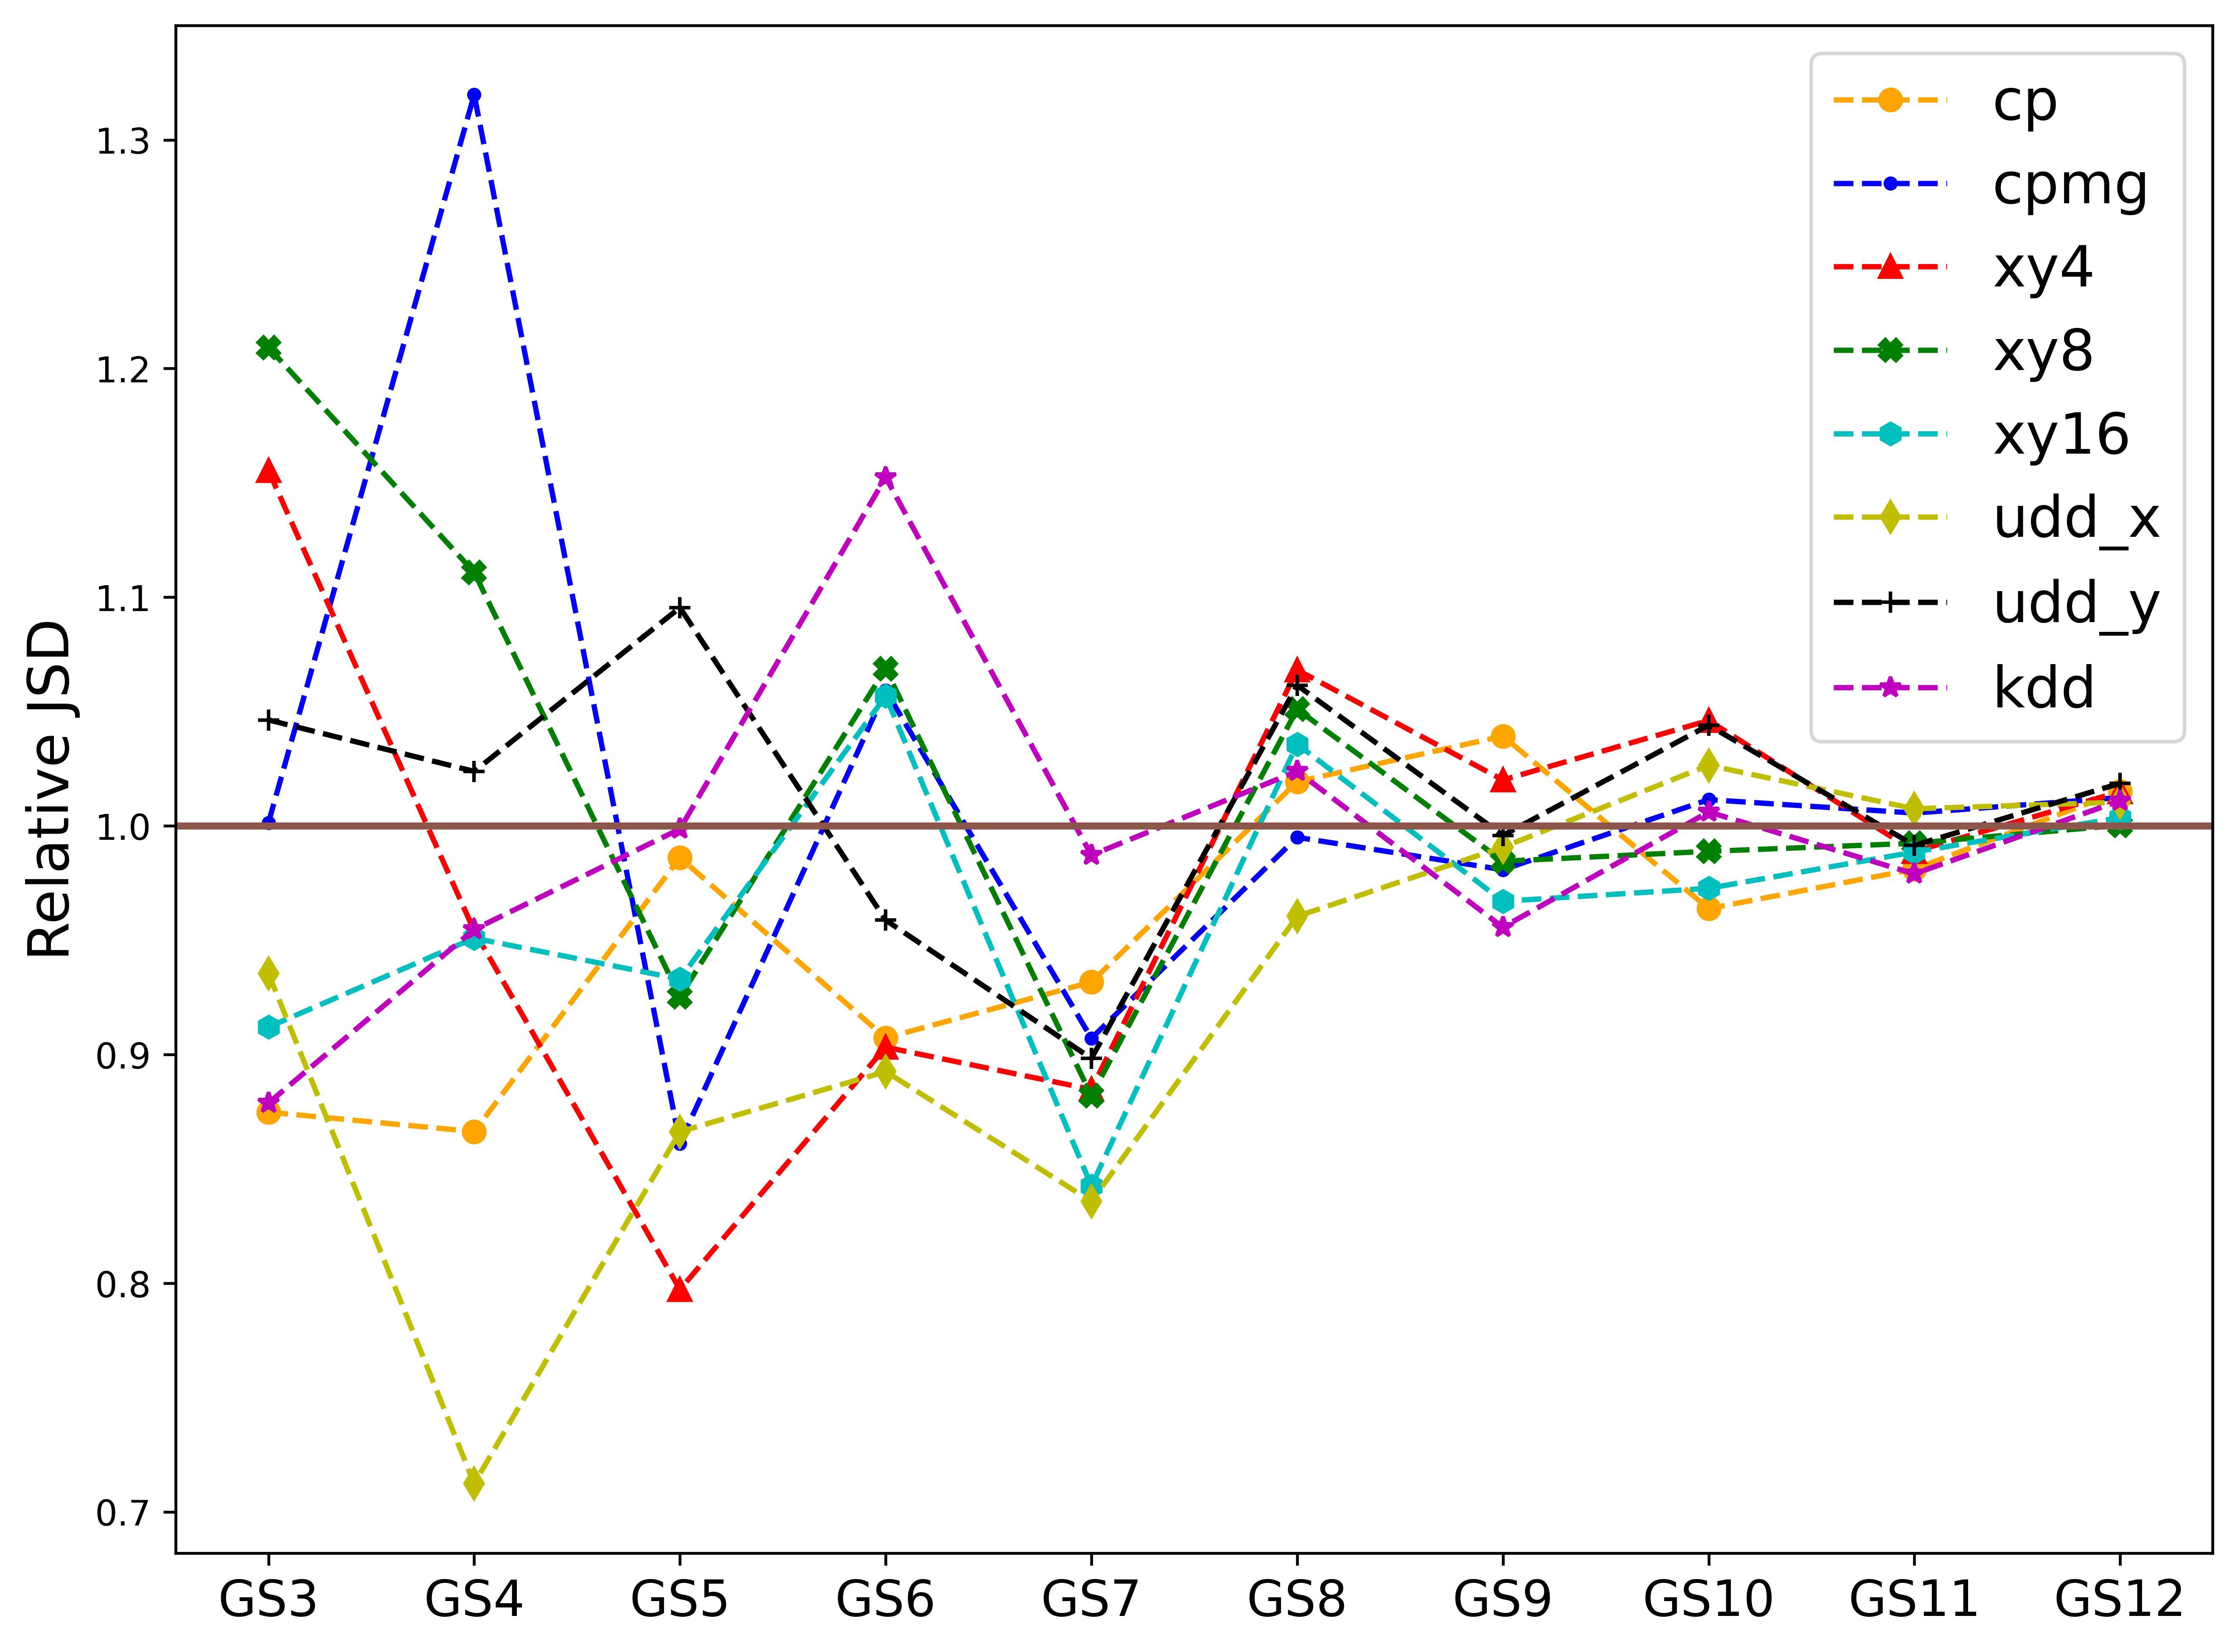

In [20]:
baseline = []

data = []
for name in circuit_names:
    result_data = gs_results_data[name]
    baseline.append(result_data[0])
    ratio = [result_data[0]/i for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)

# hahn_X = data[:, 0]
# hahn_Y = data[:, 1]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

x_ticks = circuit_names[:-2]
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

# plt.plot(X, hahn_Y, linestyle='--', marker='o', color='g', label='hahn_X')
# plt.plot(X, hahn_X, linestyle='--', marker='s', color='m', label='hahn_Y')
plt.plot(X, cp[:-2], linestyle='--', marker='o', color='orange', label='cp')
plt.plot(X, cpmg[:-2], linestyle='--', marker='.', color='b', label='cpmg')
plt.plot(X, xy4[:-2], linestyle='--', marker='^', color='r', label='xy4')
plt.plot(X, xy8[:-2], linestyle='--', marker='X', color='g', label='xy8')
plt.plot(X, xy16[:-2], linestyle='--', marker='h', color='c', label='xy16')
plt.plot(X, udd_X[:-2], linestyle='--', marker='d', color='y', label='udd_x')
plt.plot(X, udd_Y[:-2], linestyle='--', marker='+', color='k', label='udd_y')
plt.plot(X, kdd[:-2], linestyle='--', marker='*', color='m', label='kdd')
plt.axhline(1, color='tab:brown', lw=2)
plt.legend(loc='best', fontsize=16)
# ax.set_title('Relative JSD result for GS circuit on ibmq_guadalupe', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, fontsize=14)
ax.set_ylabel('Relative JSD', fontsize=16)

plt.savefig('TQE_Relat_JSD_GS_montreal.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
qft_job_ids = []
qft_jobs = []

for circuit in qft_circuits:
    circuit_list = []
    transpiled_qc = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=1)
    circuit_list.append(transpiled_qc)
    for pm in pms:
        qc_transpile = pm.run(transpiled_qc)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        circuit_list.append(qc_transpile_base)
    job = backend.run(circuit_list, shots=8192)
    qft_jobs.append(job)
    job_id = job.job_id()
    print(job_id)
    qft_job_ids.append(job_id)

if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e22394a0d3c880c21810c
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e223c68f4d6941083a774
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628e22404a0d3cf26e21810d
if applied DD for None: False
if applied DD for N

In [15]:
for job_id in qft_job_ids:
    print(job_id)

628e22394a0d3c880c21810c
628e223c68f4d6941083a774
628e22404a0d3cf26e21810d
628e22465ca8b49a3f5bf3e4
628e224b50f23d725ecb5b19
628e2252ef706928ad791053
628e225a50f23ddcbecb5b1a
628e2268386b01c8741859c0
628e22724a0d3c762c218111
628e227dd6a0613c052af851
628e228b97dfca49781294be
628e229e5ca8b46b145bf3e7


In [21]:
from scipy.spatial.distance import jensenshannon
qft_jsds = []

qft_job_ids = [
    '628e22394a0d3c880c21810c',
    '628e223c68f4d6941083a774',
    '628e22404a0d3cf26e21810d',
    '628e22465ca8b49a3f5bf3e4',
    '628e224b50f23d725ecb5b19',
    '628e2252ef706928ad791053',
    '628e225a50f23ddcbecb5b1a',
    '628e2268386b01c8741859c0',
    '628e22724a0d3c762c218111',
    '628e227dd6a0613c052af851',
    '628e228b97dfca49781294be',
    '628e229e5ca8b46b145bf3e7'
]

shots = 8192

for i, circuit in enumerate(qft_circuits):
    ideal_counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts()
    result_counts = backend.retrieve_job(qft_job_ids[i]).result().get_counts()
    jsd = []
    for result_count in result_counts:
        p_ideal, p_result = convert_count_to_prob(result_count, ideal_counts, shots=shots)
        jsd.append(jensenshannon(p_ideal, p_result))
    qft_jsds.append(jsd)

circuit_names = ['QFT3', 'QFT4', 'QFT5', 'QFT6', 'QFT7', 'QFT8', 'QFT9', 'QFT10', 'QFT11', 'QFT12', 'QFT13', 'QFT14']
DD_sequences = ['no_dd', 'hahn_X', 'hahn_Y', 'CP', 'CPMG', 'xy4', 'xy8', 'xy16', 'udd1', 'udd2', 'kdd']

qft_results_data = {}

for i, name in enumerate(circuit_names):
    print(f'---------Result of circuit {name} -------------')
    for j, jsd in enumerate(qft_jsds[i]):
        print(f'jsd result of {DD_sequences[j]}: {jsd}')
    qft_results_data[name] = qft_jsds[i]

---------Result of circuit QFT3 -------------
jsd result of no_dd: 0.04302677190010599
jsd result of hahn_X: 0.03980514078979756
jsd result of hahn_Y: 0.04597739404588308
jsd result of CP: 0.05841579956977539
jsd result of CPMG: 0.04543283989590021
jsd result of xy4: 0.04927848629359119
jsd result of xy8: 0.0440262439096033
jsd result of xy16: 0.047573119654132794
jsd result of udd1: 0.05487353699475501
jsd result of udd2: 0.046516411311196215
jsd result of kdd: 0.04499580352104076
---------Result of circuit QFT4 -------------
jsd result of no_dd: 0.07493044336710361
jsd result of hahn_X: 0.06893687990287456
jsd result of hahn_Y: 0.08224313572783344
jsd result of CP: 0.06422676166966525
jsd result of CPMG: 0.09717683163023277
jsd result of xy4: 0.09894153162853368
jsd result of xy8: 0.09551065422606293
jsd result of xy16: 0.08066713868796287
jsd result of udd1: 0.1030252647352199
jsd result of udd2: 0.08496240907138485
jsd result of kdd: 0.12243843624713453
---------Result of circuit Q

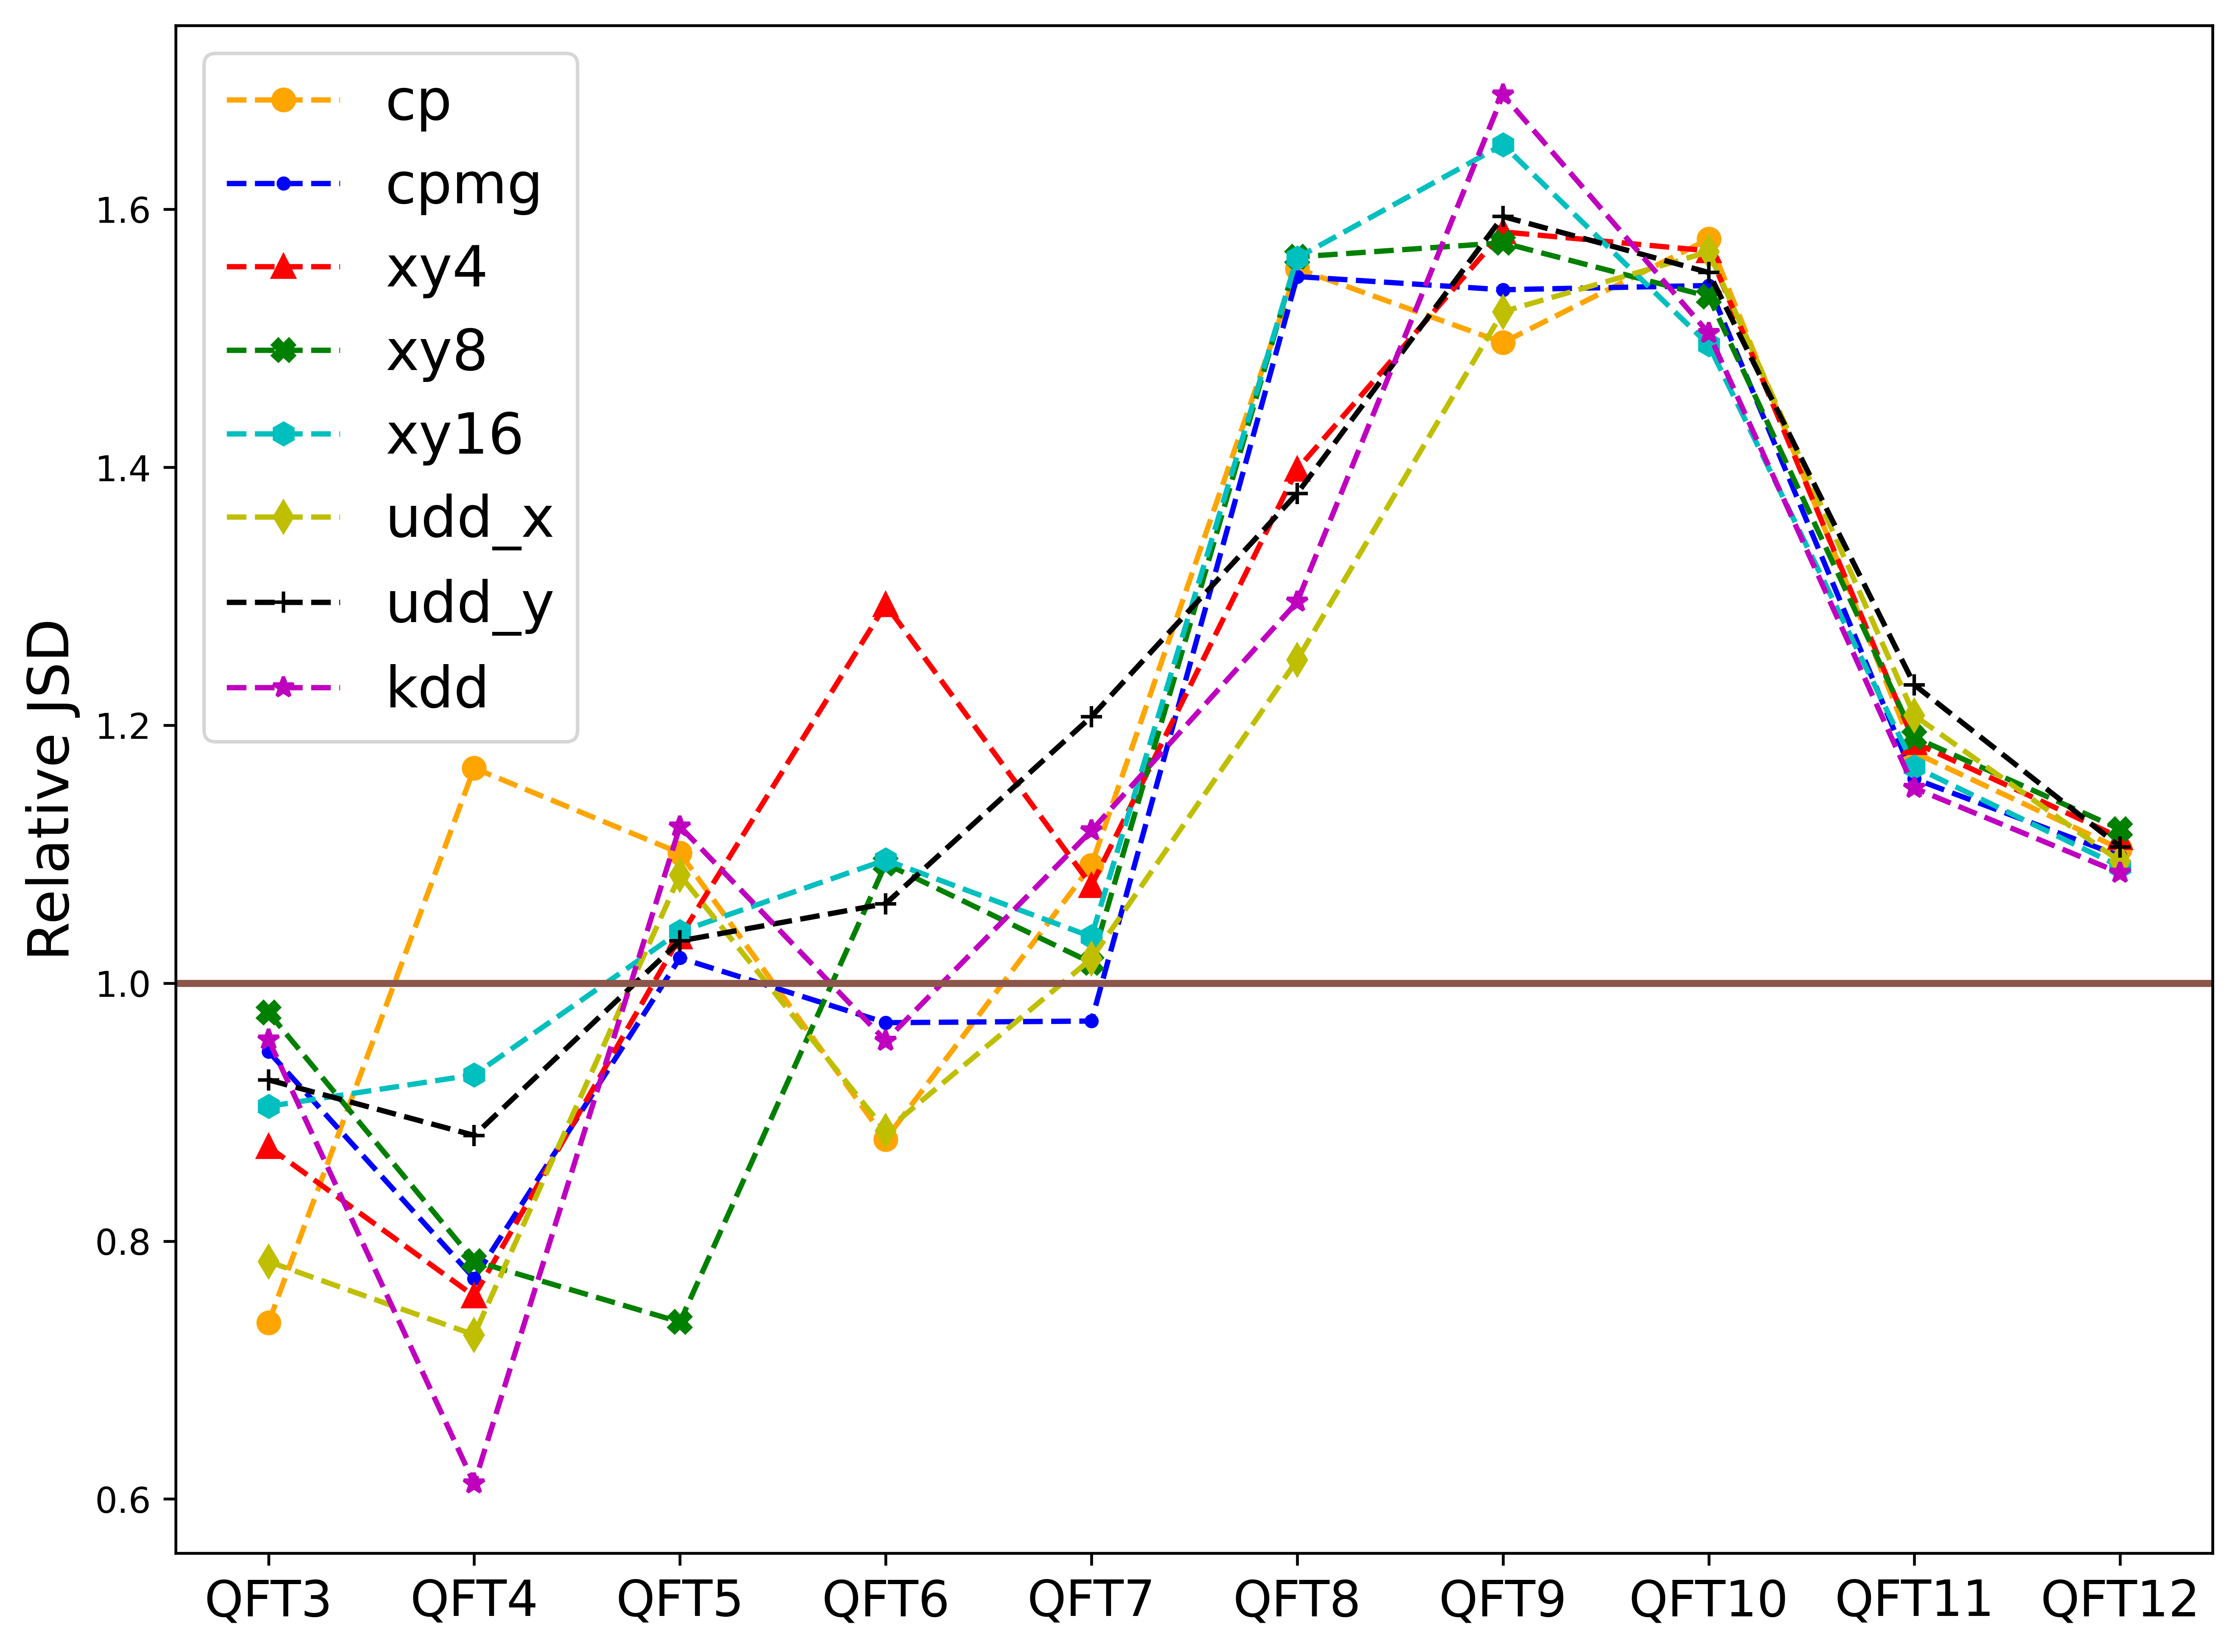

In [22]:
import matplotlib.pyplot as plt
baseline = []

data = []
for name in circuit_names:
    result_data = qft_results_data[name]
    baseline.append(result_data[0])
    ratio = [result_data[0]/i for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)

# hahn_X = data[:, 0]
# hahn_Y = data[:, 1]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

x_ticks = circuit_names[:-2]
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

# plt.plot(X, hahn_Y, linestyle='--', marker='o', color='g', label='hahn_X')
# plt.plot(X, hahn_X, linestyle='--', marker='s', color='m', label='hahn_Y')
plt.plot(X, cp[:-2], linestyle='--', marker='o', color='orange', label='cp')
plt.plot(X, cpmg[:-2], linestyle='--', marker='.', color='b', label='cpmg')
plt.plot(X, xy4[:-2], linestyle='--', marker='^', color='r', label='xy4')
plt.plot(X, xy8[:-2], linestyle='--', marker='X', color='g', label='xy8')
plt.plot(X, xy16[:-2], linestyle='--', marker='h', color='c', label='xy16')
plt.plot(X, udd_X[:-2], linestyle='--', marker='d', color='y', label='udd_x')
plt.plot(X, udd_Y[:-2], linestyle='--', marker='+', color='k', label='udd_y')
plt.plot(X, kdd[:-2], linestyle='--', marker='*', color='m', label='kdd')
plt.axhline(1, color='tab:brown', lw=2)
plt.legend(loc='best', fontsize=16)
# ax.set_title('Relative JSD result for QFT circuit on ibmq_guadalupe', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, fontsize=14)
ax.set_ylabel('Relative JSD', fontsize=16)

plt.savefig('TQE_Relat_JSD_QFT_montreal.pdf', bbox_inches='tight', pad_inches=0)